# 1.Pronciple Of GPU and CUDA

The reference for the fundamental section can be found at: https://www.diva-portal.org/smash/get/diva2:447977/FULLTEXT01.pdf

## 1.1 Architecture

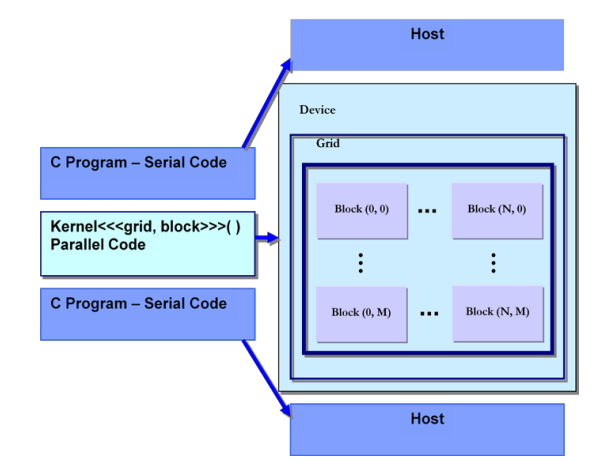

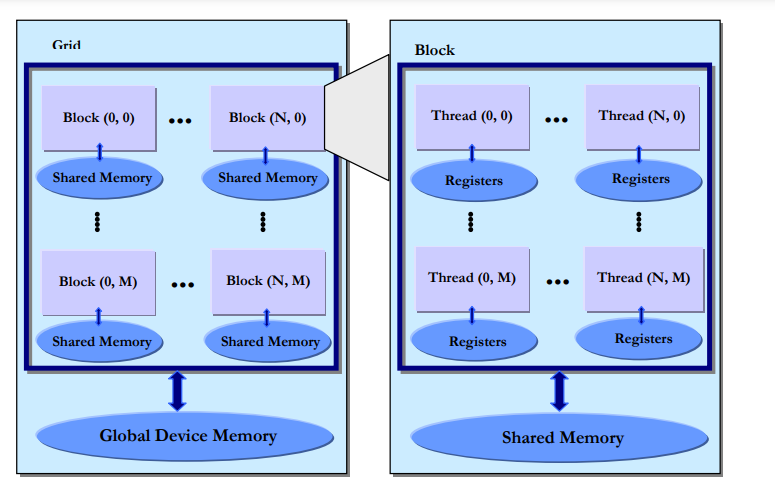



---


Shared memory is “local” to each multiprocessor unlike device memory and allows
more efficient local synchronization. It is divided into many parts. Each thread block within multiprocessor accesses its own part of shared memory and this part of shared memory is not accessible by any other thread block of this multiprocessor or of some other multiprocessor
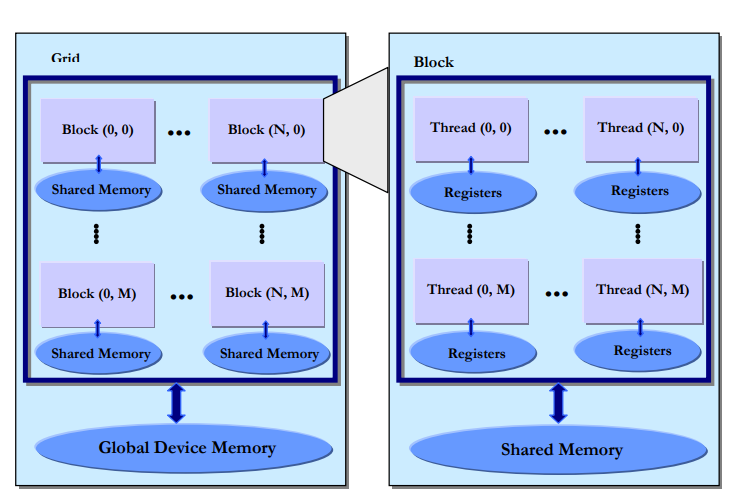

## 1.2 Data Flow and Functions

1. Allocate memory on host (CPU) and device (GPU) separately. Device memory is readable and writable by the host through the memory copy functions.
2. Copy data from host to device using CUDA API if required.
3. Kernel function executes parallel on each core.
4. Copy data back from device to host using CUDA API

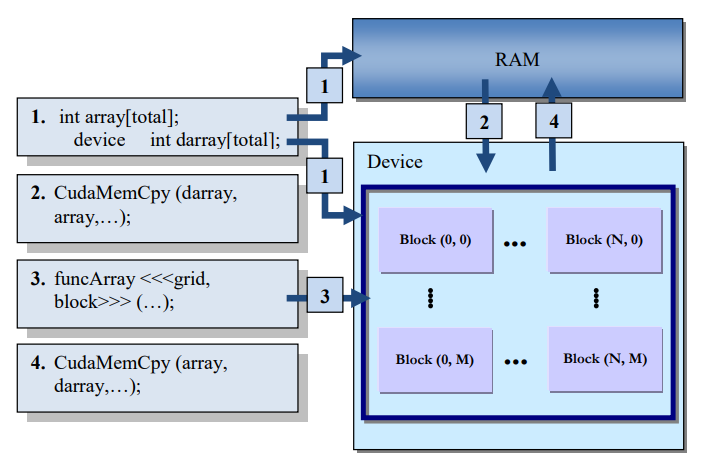

## 1.3 Install

In [1]:
!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter
!nvidia-smi
!nvcc --version

Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpxubwtziu".
Fri Nov 22 18:25:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4 

## 1.4 Hello World

In [20]:
%%cuda
#include <algorithm>
#include <cassert>
#include <iostream>
#include <vector>
using namespace std;
__global__ void hello(){
 printf("Hello from block: %u, thread: %u\n", blockIdx.x, threadIdx.x);
}

int main(){
 hello<<<2, 2>>>();
 cudaDeviceSynchronize();
}

Hello from block: 0, thread: 0
Hello from block: 0, thread: 1
Hello from block: 1, thread: 0
Hello from block: 1, thread: 1



# 2. Matrix Multiplication

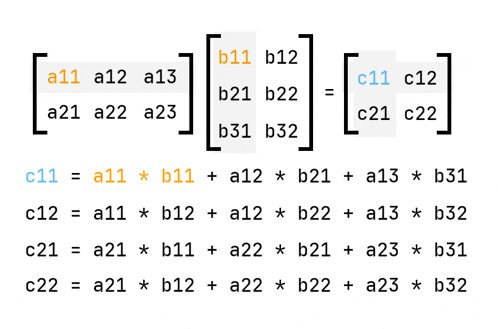

## 2.1. Sequential (1 Block and 1 Thread)

In [9]:
%%cuda
#include <iostream>
using namespace std;

const int N = 4;

__global__ void matMulSequential(float *A, float *B, float *C, int N) {
    if (threadIdx.x == 0 && threadIdx.y == 0) {
        for (int i = 0; i < N; i++) {
            for (int j = 0; j < N; j++) {
                float sum = 0.0f;
                for (int k = 0; k < N; k++) {
                    sum += A[i * N + k] * B[k * N + j];
                }
                C[i * N + j] = sum;
            }
        }
    }
}

int main() {
    float hA[N * N] = {1, 2, 3, 4,
                       5, 6, 7, 8,
                       9, 10, 11, 12,
                       13, 14, 15, 16};

    float hB[N * N] = {16, 15, 14, 13,
                       12, 11, 10, 9,
                       8, 7, 6, 5,
                       4, 3, 2, 1};

    float hC[N * N] = {0};
    float *dA, *dB, *dC;

    cudaMalloc((void **)&dA, N * N * sizeof(float));
    cudaMalloc((void **)&dB, N * N * sizeof(float));
    cudaMalloc((void **)&dC, N * N * sizeof(float));

    cudaMemcpy(dA, hA, N * N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(dB, hB, N * N * sizeof(float), cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(1, 1);
    dim3 numBlocks(1, 1);

    matMulSequential<<<numBlocks, threadsPerBlock>>>(dA, dB, dC, N);
    cudaDeviceSynchronize();

    cudaMemcpy(hC, dC, N * N * sizeof(float), cudaMemcpyDeviceToHost);

    cout << "Result Matrix (Sequential):\n";
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            cout << hC[i * N + j] << "\t";
        }
        cout << "\n";
    }

    cudaFree(dA);
    cudaFree(dB);
    cudaFree(dC);

    return 0;
}


Result Matrix (Sequential):
80	70	60	50	
240	214	188	162	
400	358	316	274	
560	502	444	386	



## 2.2 1 Block and 4 Threads

In [10]:
%%cuda
#include <iostream>
using namespace std;

const int N = 4;

__global__ void matMul1x4(float *A, float *B, float *C, int N) {
    int row = threadIdx.x;
    if (row < N) {
        for (int col = 0; col < N; col++) {
            float sum = 0.0f;
            for (int k = 0; k < N; k++) {
                sum += A[row * N + k] * B[k * N + col];
            }
            C[row * N + col] = sum;
        }
    }
}

int main() {
    float hA[N * N] = {1, 2, 3, 4,
                       5, 6, 7, 8,
                       9, 10, 11, 12,
                       13, 14, 15, 16};

    float hB[N * N] = {16, 15, 14, 13,
                       12, 11, 10, 9,
                       8, 7, 6, 5,
                       4, 3, 2, 1};

    float hC[N * N] = {0};
    float *dA, *dB, *dC;

    //Aloccate memory to host
    cudaMalloc((void **)&dA, N * N * sizeof(float));
    cudaMalloc((void **)&dB, N * N * sizeof(float));
    cudaMalloc((void **)&dC, N * N * sizeof(float));

    //The data from the host is copied to the device using CUDA API cudaMemCpy().
    cudaMemcpy(dA, hA, N * N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(dB, hB, N * N * sizeof(float), cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(4);
    dim3 numBlocks(1);

    matMul1x4<<<numBlocks, threadsPerBlock>>>(dA, dB, dC, N);
    cudaDeviceSynchronize();

    cudaMemcpy(hC, dC, N * N * sizeof(float), cudaMemcpyDeviceToHost);

    cout << "Result Matrix (1x4 Threads):\n";
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            cout << hC[i * N + j] << "\t";
        }
        cout << "\n";
    }

    cudaFree(dA);
    cudaFree(dB);
    cudaFree(dC);

    return 0;
}


Result Matrix (1x4 Threads):
80	70	60	50	
240	214	188	162	
400	358	316	274	
560	502	444	386	



## 2.3. 1 Block and 4x4 Threads

In [17]:
%%cuda
#include <iostream>
using namespace std;

const int N = 4;

__global__ void matMul1x16(float *A, float *B, float *C, int N) {
    int row = threadIdx.y;
    int col = threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;

        // Print which thread calculates which index
        printf("Block (0,0), Thread (%d,%d) -> C[%d][%d]\n", threadIdx.y, threadIdx.x, row, col);
    }
}

int main() {
    float hA[N * N] = {1, 2, 3, 4,
                       5, 6, 7, 8,
                       9, 10, 11, 12,
                       13, 14, 15, 16};

    float hB[N * N] = {16, 15, 14, 13,
                       12, 11, 10, 9,
                       8, 7, 6, 5,
                       4, 3, 2, 1};

    float hC[N * N] = {0};
    float *dA, *dB, *dC;

    cudaMalloc((void **)&dA, N * N * sizeof(float));
    cudaMalloc((void **)&dB, N * N * sizeof(float));
    cudaMalloc((void **)&dC, N * N * sizeof(float));

    cudaMemcpy(dA, hA, N * N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(dB, hB, N * N * sizeof(float), cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(4, 4);  // 4x4 threads in one block
    dim3 numBlocks(1, 1);       // Single block

    matMul1x16<<<numBlocks, threadsPerBlock>>>(dA, dB, dC, N);
    cudaDeviceSynchronize();

    cudaMemcpy(hC, dC, N * N * sizeof(float), cudaMemcpyDeviceToHost);

    cout << "Result Matrix (1 Block, 4x4 Threads):\n";
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            cout << hC[i * N + j] << "\t";
        }
        cout << "\n";
    }

    cudaFree(dA);
    cudaFree(dB);
    cudaFree(dC);

    return 0;
}


Block (0,0), Thread (0,0) -> C[0][0]
Block (0,0), Thread (0,1) -> C[0][1]
Block (0,0), Thread (0,2) -> C[0][2]
Block (0,0), Thread (0,3) -> C[0][3]
Block (0,0), Thread (1,0) -> C[1][0]
Block (0,0), Thread (1,1) -> C[1][1]
Block (0,0), Thread (1,2) -> C[1][2]
Block (0,0), Thread (1,3) -> C[1][3]
Block (0,0), Thread (2,0) -> C[2][0]
Block (0,0), Thread (2,1) -> C[2][1]
Block (0,0), Thread (2,2) -> C[2][2]
Block (0,0), Thread (2,3) -> C[2][3]
Block (0,0), Thread (3,0) -> C[3][0]
Block (0,0), Thread (3,1) -> C[3][1]
Block (0,0), Thread (3,2) -> C[3][2]
Block (0,0), Thread (3,3) -> C[3][3]
Result Matrix (1 Block, 4x4 Threads):
80	70	60	50	
240	214	188	162	
400	358	316	274	
560	502	444	386	



## 2.4. 2 Blocks and 2x2 Threads


In [18]:
%%cuda
#include <iostream>
using namespace std;

const int N = 4;

__global__ void matMul4Blocks(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;

        // Print which block and thread calculates which index
        printf("Block (%d,%d), Thread (%d,%d) -> C[%d][%d]\n",
               blockIdx.y, blockIdx.x, threadIdx.y, threadIdx.x, row, col);
    }
}

int main() {
    float hA[N * N] = {1, 2, 3, 4,
                       5, 6, 7, 8,
                       9, 10, 11, 12,
                       13, 14, 15, 16};

    float hB[N * N] = {16, 15, 14, 13,
                       12, 11, 10, 9,
                       8, 7, 6, 5,
                       4, 3, 2, 1};

    float hC[N * N] = {0};
    float *dA, *dB, *dC;

    cudaMalloc((void **)&dA, N * N * sizeof(float));
    cudaMalloc((void **)&dB, N * N * sizeof(float));
    cudaMalloc((void **)&dC, N * N * sizeof(float));

    cudaMemcpy(dA, hA, N * N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(dB, hB, N * N * sizeof(float), cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(2, 2);  // 2x2 threads per block
    dim3 numBlocks(2, 2);       // 2x2 grid of blocks

    matMul4Blocks<<<numBlocks, threadsPerBlock>>>(dA, dB, dC, N);
    cudaDeviceSynchronize();

    cudaMemcpy(hC, dC, N * N * sizeof(float), cudaMemcpyDeviceToHost);

    cout << "Result Matrix (4 Blocks, 2x2 Threads):\n";
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            cout << hC[i * N + j] << "\t";
        }
        cout << "\n";
    }

    cudaFree(dA);
    cudaFree(dB);
    cudaFree(dC);

    return 0;
}


Block (1,0), Thread (0,0) -> C[2][0]
Block (1,0), Thread (0,1) -> C[2][1]
Block (1,0), Thread (1,0) -> C[3][0]
Block (1,0), Thread (1,1) -> C[3][1]
Block (1,1), Thread (0,0) -> C[2][2]
Block (1,1), Thread (0,1) -> C[2][3]
Block (1,1), Thread (1,0) -> C[3][2]
Block (1,1), Thread (1,1) -> C[3][3]
Block (0,1), Thread (0,0) -> C[0][2]
Block (0,1), Thread (0,1) -> C[0][3]
Block (0,1), Thread (1,0) -> C[1][2]
Block (0,1), Thread (1,1) -> C[1][3]
Block (0,0), Thread (0,0) -> C[0][0]
Block (0,0), Thread (0,1) -> C[0][1]
Block (0,0), Thread (1,0) -> C[1][0]
Block (0,0), Thread (1,1) -> C[1][1]
Result Matrix (4 Blocks, 2x2 Threads):
80	70	60	50	
240	214	188	162	
400	358	316	274	
560	502	444	386	



## 2.5. 2x2 Blocks and 2x2 Threads

In [19]:
%%cuda
#include <iostream>
using namespace std;

const int N = 4;

__global__ void matMul2x2Blocks(float *A, float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < N; k++) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;

        // Print which block and thread calculates which index
        printf("Block (%d,%d), Thread (%d,%d) -> C[%d][%d]\n",
               blockIdx.y, blockIdx.x, threadIdx.y, threadIdx.x, row, col);
    }
}

int main() {
    float hA[N * N] = {1, 2, 3, 4,
                       5, 6, 7, 8,
                       9, 10, 11, 12,
                       13, 14, 15, 16};

    float hB[N * N] = {16, 15, 14, 13,
                       12, 11, 10, 9,
                       8, 7, 6, 5,
                       4, 3, 2, 1};

    float hC[N * N] = {0};
    float *dA, *dB, *dC;

    cudaMalloc((void **)&dA, N * N * sizeof(float));
    cudaMalloc((void **)&dB, N * N * sizeof(float));
    cudaMalloc((void **)&dC, N * N * sizeof(float));

    cudaMemcpy(dA, hA, N * N * sizeof(float), cudaMemcpyHostToDevice);
    cudaMemcpy(dB, hB, N * N * sizeof(float), cudaMemcpyHostToDevice);

    dim3 threadsPerBlock(2, 2);  // 2x2 threads per block
    dim3 numBlocks(2, 2);       // 2x2 grid of blocks

    matMul2x2Blocks<<<numBlocks, threadsPerBlock>>>(dA, dB, dC, N);
    cudaDeviceSynchronize();

    cudaMemcpy(hC, dC, N * N * sizeof(float), cudaMemcpyDeviceToHost);

    cout << "Result Matrix (2x2 Blocks, 2x2 Threads):\n";
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            cout << hC[i * N + j] << "\t";
        }
        cout << "\n";
    }

    cudaFree(dA);
    cudaFree(dB);
    cudaFree(dC);

    return 0;
}


Block (1,0), Thread (0,0) -> C[2][0]
Block (1,0), Thread (0,1) -> C[2][1]
Block (1,0), Thread (1,0) -> C[3][0]
Block (1,0), Thread (1,1) -> C[3][1]
Block (1,1), Thread (0,0) -> C[2][2]
Block (1,1), Thread (0,1) -> C[2][3]
Block (1,1), Thread (1,0) -> C[3][2]
Block (1,1), Thread (1,1) -> C[3][3]
Block (0,1), Thread (0,0) -> C[0][2]
Block (0,1), Thread (0,1) -> C[0][3]
Block (0,1), Thread (1,0) -> C[1][2]
Block (0,1), Thread (1,1) -> C[1][3]
Block (0,0), Thread (0,0) -> C[0][0]
Block (0,0), Thread (0,1) -> C[0][1]
Block (0,0), Thread (1,0) -> C[1][0]
Block (0,0), Thread (1,1) -> C[1][1]
Result Matrix (2x2 Blocks, 2x2 Threads):
80	70	60	50	
240	214	188	162	
400	358	316	274	
560	502	444	386	

